# Imports and preprocessing

## Librairies Import

In [ ]:
from scipy.stats import norm
from math import erf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from statsmodels.nonparametric.kernel_regression import KernelReg
import warnings
warnings.filterwarnings("ignore")

## Data Import

 The dataset we'll mainly use in this demonstration is the Natixis Stock between 2015 and 2018.

In [ ]:
data = pd.read_csv('Natixis stock (dataset TD12).txt', delimiter="\t", header=None)

In [ ]:
print(type(data))
len(data)

<class 'pandas.core.frame.DataFrame'>


1023

## Calculation of returns

In [ ]:
data = data.rename(columns={0:"date",1:"stock_value"})
data['date'] = pd.to_datetime(data['date'])
data["stock_value"] = data["stock_value"].str.replace(',', '.').astype(float)

stock_values = data['stock_value']

returns = np.zeros(len(stock_values))

for i in range(1, len(stock_values)):
    returns[i] = (stock_values[i] - stock_values[i-1]) / stock_values[i-1] * 100

data['returns'] = returns
data['returns'] = data['returns'].round(3)
returns = data['returns']
data.head()

,date,stock_value,returns
0,2015-02-01,5.621,0.000
1,2015-05-01,5.424,-3.505
2,2015-06-01,5.329,-1.751
3,2015-07-01,5.224,-1.970
4,2015-08-01,5.453,4.384


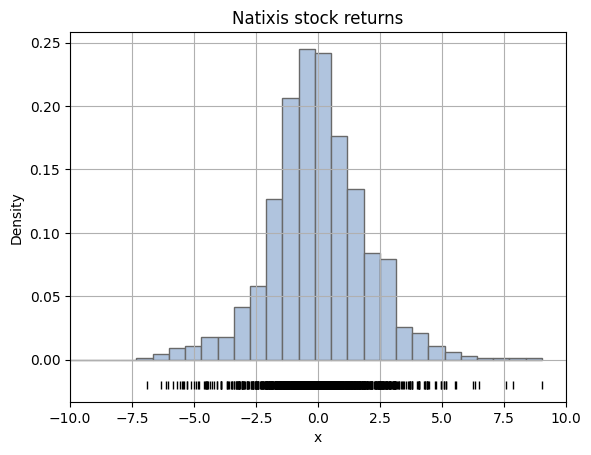

In [ ]:
plt.hist(returns, bins=40, density=True,edgecolor='dimgrey', color='lightsteelblue')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.xlim(-10,10)
plt.title('Natixis stock returns')
plt.plot(returns, np.full_like(returns, -0.02), '|k', markeredgewidth=1,color="black")
plt.show()

# KDE Implementation

## Statistical tools definition

First, we implement the functions that calculate the paramaters of a gaussian distribution : mu and sigma

In [ ]:
def parameters(data):
    n = len(data)
    mu = sum(data) / n
    sigma = (sum((x - mu) ** 2 for x in data) / n) ** 0.5
    return mu, sigma

Then, we implement the pdf and cdf of a gaussian distribution as the following :

In [ ]:
def norm_pdf(x, mu, sigma):
    return 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

In [ ]:
def norm_cdf(x, mean, std):
  return (1+ erf((x-mean)/std+2**0.5))/2

Here is also the implementation of two function : Triweight and Epanechnikov that we will use to compare the different types of Kernel.

In [ ]:
def triweight(x):
    return (35/32) * (1 - x**2)**3 * (np.abs(x) <= 1)

def epa(x):
    return 0.75 * (1 - x**2) if np.abs(x) <= 1 else 0

def bi(x):
  return (15/16) * ((1 - x)**2)**2 * (np.abs(x) <= 1)

We can now create the kernel density function defined as :

In [ ]:
def kernel_density_estimate(data, x, bandwidth, kernel='gaussian'):
    mu, sigma = parameters(data)
    kernel_vals = 0
    for i in range(len(data)):
      if kernel == 'gaussian':
          kernel_vals += norm_pdf(((x - data[i]) / bandwidth), mu, sigma)
      elif kernel == 'tri':
          kernel_vals += triweight((x - data[i]) / bandwidth)
      elif kernel == 'epa':
          u = (x - data[i]) / bandwidth
          kernel_vals += 0.75 * (1 - u**2) * (np.abs(u) <= 1)
      elif kernel == "bi":
          kernel_vals += bi((x - data[i]) / bandwidth)
      else:
          raise ValueError("Invalid kernel type. Available options: 'gaussian', 'tri', 'epa'")

    return kernel_vals / (len(data) * bandwidth)

## Types of Kernel functions

Traditionally, kernel density is often calculated with a Gaussian kernel, ie a normal law, but we can also use other kernels: cosines, Epanechnikov...

Let's compare the Gaussian distribution and diffent Kernel functions for the same arbitrary bandwidth:

In [ ]:
x_values = np.linspace(np.min(returns), np.max(returns), 1000)
mu, sigma = parameters(returns)
print("Moyenne :",round(mu,3), "Ecart-type :",round(sigma,3))

Moyenne : -0.01 Ecart-type : 2.027


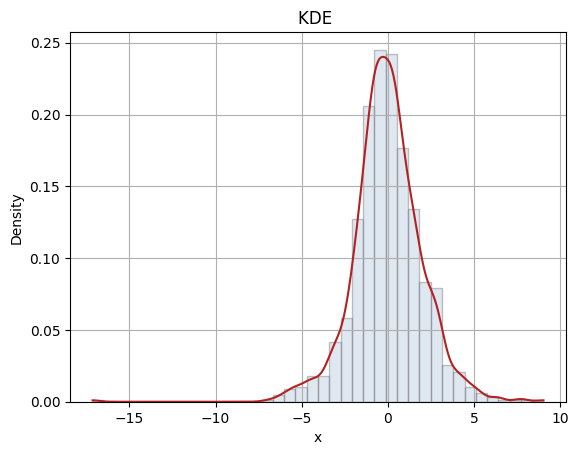

In [ ]:
KDE = [kernel_density_estimate(returns, x, 0.2) for x in x_values]
plt.hist(returns, bins=40, density=True,edgecolor='dimgrey', alpha=0.4, color='lightsteelblue')
plt.plot(x_values, KDE,color ='firebrick')
plt.xlabel('x')
plt.ylabel('Density')
plt.grid(True)
plt.title("KDE ")
plt.show()

In [ ]:
NORM = [norm_pdf(x, mu, sigma) for x in x_values]
KDE = [kernel_density_estimate(returns, x, 0.2) for x in x_values]
EPA =  [kernel_density_estimate(returns, x, 0.2, kernel='epa') for x in x_values]
TRI = [kernel_density_estimate(returns, x, 0.2, kernel = 'tri') for x in x_values]

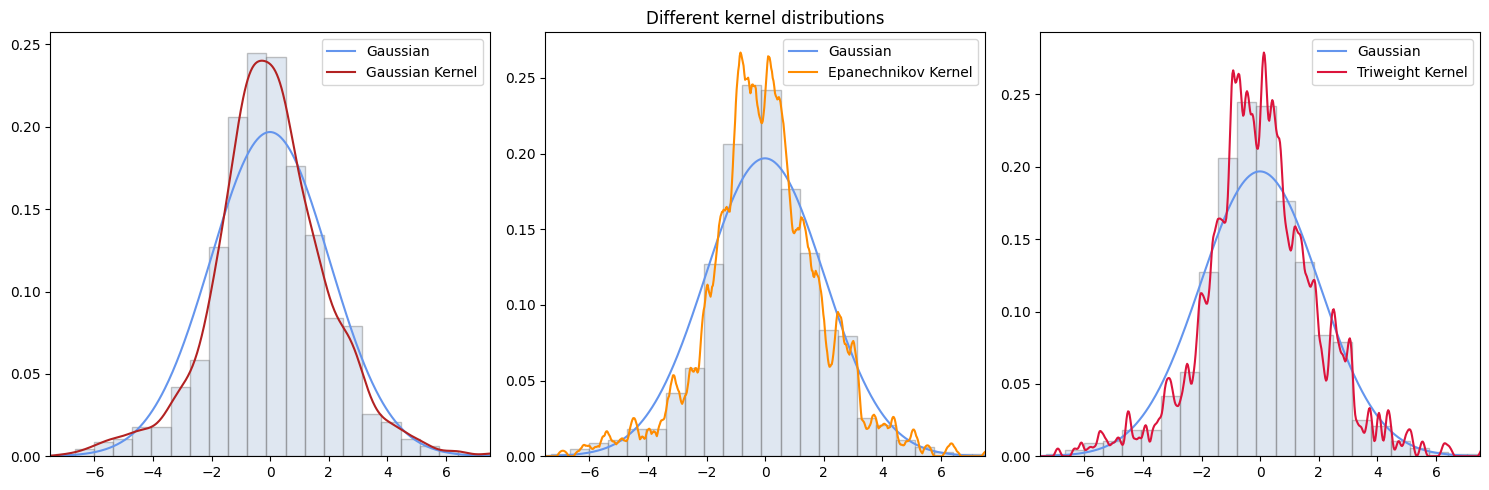

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(x_values, NORM, label='Gaussian',color='cornflowerblue')
ax1.plot(x_values, KDE, label='Gaussian Kernel',color ='firebrick')
ax1.legend()
ax1.hist(returns, bins=40, density=True, alpha=0.4, color='lightsteelblue',edgecolor='dimgrey')
ax1.set_xlim(-7.5, 7.5)

ax2.plot(x_values, NORM, label='Gaussian',color='cornflowerblue')
ax2.plot(x_values, EPA, label='Epanechnikov Kernel',color ='darkorange')
ax2.set_title('Different kernel distributions')
ax2.legend()
ax2.hist(returns, bins=40, density=True, alpha=0.4, color='lightsteelblue',edgecolor='dimgrey')
ax2.set_xlim(-7.5, 7.5)

ax3.plot(x_values, NORM, label='Gaussian',color='cornflowerblue')
ax3.plot(x_values, TRI, label='Triweight Kernel',color ='crimson')
ax3.legend()
ax3.hist(returns, bins=40, density=True, alpha=0.4, color='lightsteelblue',edgecolor='dimgrey')
ax3.set_xlim(-7.5, 7.5)

plt.tight_layout()
plt.show()

This naive example highlights two things :

-A Gaussian distribution is not always the best solution to fit the returns distribution. A kernel density estimation seems to provide better result.

-There are planty of kernel function that can be used


Please note that for the rest of the presentation, we will use a Gaussian kernel in our calculations.

## Importance of the bandwidth choice

### Uni-modal data distribution

Let's try to compare the Kernel density for different values of the bandwidth.

In [ ]:
KDE2 = [kernel_density_estimate(returns, x, 0.2) for x in x_values]
KDE3 = [kernel_density_estimate(returns, x, 1.3) for x in x_values]
KDE4 = [kernel_density_estimate(returns, x, 0.075) for x in x_values]

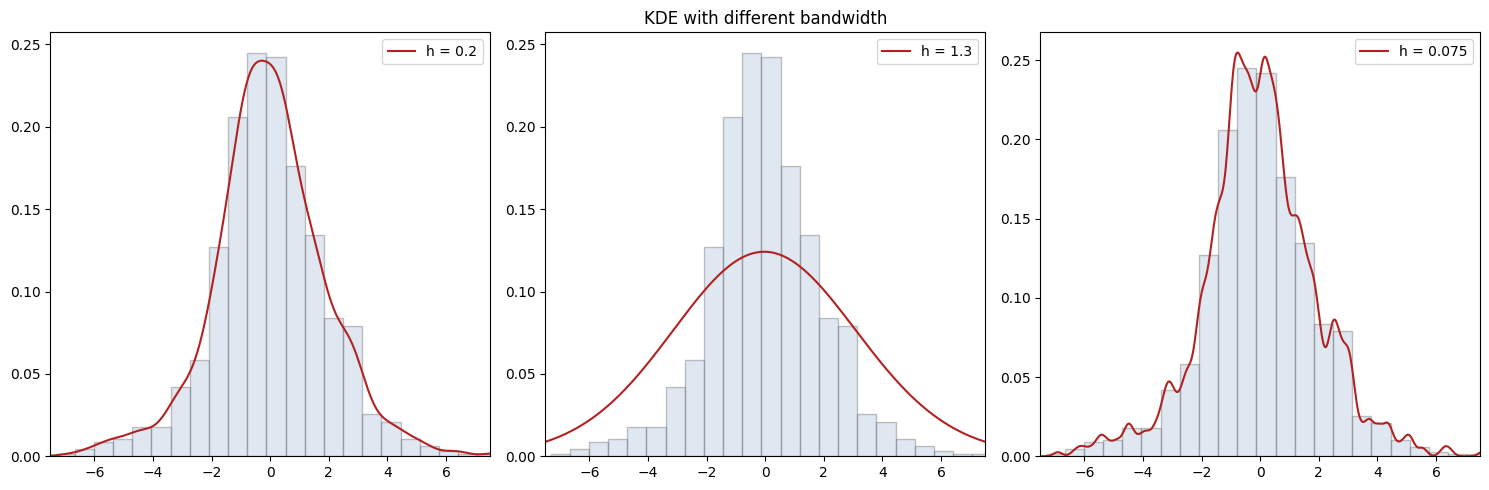

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(x_values, KDE2,color ='firebrick', label="h = 0.2")
ax1.hist(returns, bins=40, density=True, alpha=0.4, color='lightsteelblue',edgecolor='dimgrey')
ax1.set_xlim(-7.5, 7.5)
ax1.legend()

ax2.plot(x_values, KDE3,color ='firebrick', label="h = 1.3")
ax2.set_title('KDE with different bandwidth')
ax2.hist(returns, bins=40, density=True, alpha=0.4, color='lightsteelblue',edgecolor='dimgrey')
ax2.set_xlim(-7.5, 7.5)
ax2.legend()

ax3.plot(x_values, KDE4,color ='firebrick', label="h = 0.075")
ax3.hist(returns, bins=40, density=True, alpha=0.4, color='lightsteelblue',edgecolor='dimgrey')
ax3.set_xlim(-7.5, 7.5)
ax3.legend()

plt.tight_layout()
plt.show()

The result of the graphs comparison highlights the major role of the bandwidth parameter selection for data fitting with the kernel density estimation. In fact, the KDE with a bandwidth of 1.3 is clearly underfitting the histogram resulting in data loss => clear case of oversmoothing.
In the contrary, when the bandwidth equals 0.075, the model is overfitting the observations, providing a poor generalization to other datas.
At first glance, a bandwidth of 0.2 seems to be the best choice over the three.

### Multi-modal data distribution

After a first comparison of the bandwidth, it is clear that the case of oversmoothing is not only a loss of information for our model but can lead to the disappearance of the multimodal character of a distribution. Let's illustrate this with an example :

In [ ]:
np.random.seed(0)
mode1_data = np.random.normal(-6, 0.5, 500)
mode2_data = np.random.normal(-3, 1, 800)
mode3_data = np.random.normal(0, 1, 600)
mode4_data = np.random.normal(3, 1, 400)
mode5_data = np.random.normal(6, 0.5, 300)
multimodal_data = np.concatenate((mode1_data, mode2_data, mode3_data, mode4_data, mode5_data))

In [ ]:
KDE2_binormal = [kernel_density_estimate(multimodal_data, x, 0.15) for x in x_values]
KDE3_binormal = [kernel_density_estimate(multimodal_data, x, 1.9) for x in x_values]
KDE4_binormal = [kernel_density_estimate(multimodal_data, x, 0.02) for x in x_values]

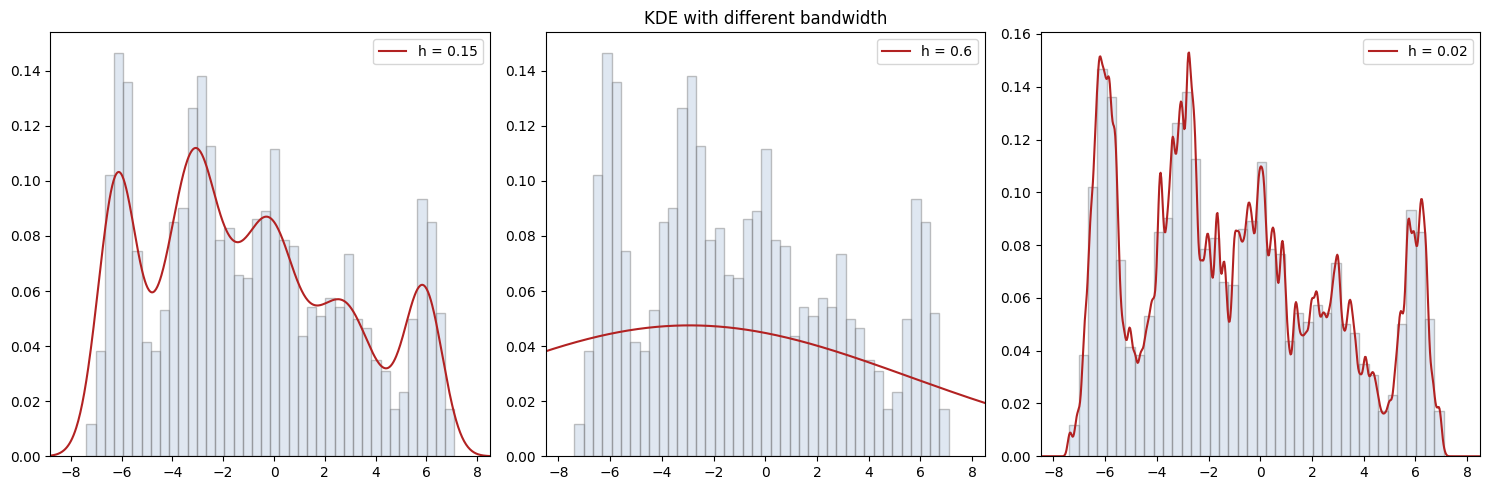

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(x_values, KDE2_binormal,color ='firebrick', label="h = 0.15")
ax1.set_xlim(-8.8, 8.5)
ax1.hist(multimodal_data, bins=40, density=True, alpha=0.4, color='lightsteelblue',edgecolor='dimgrey')
ax1.legend()

ax2.plot(x_values, KDE3_binormal,color ='firebrick', label="h = 0.6")
ax2.set_title('KDE with different bandwidth')
ax2.set_xlim(-8.5, 8.5)
ax2.hist(multimodal_data, bins=40, density=True, alpha=0.4, color='lightsteelblue',edgecolor='dimgrey')
ax2.legend()

ax3.plot(x_values, KDE4_binormal,color ='firebrick', label="h = 0.02")
ax3.set_xlim(-8.5, 8.5)
ax3.hist(multimodal_data, bins=40, density=True, alpha=0.4, color='lightsteelblue',edgecolor='dimgrey')
ax3.legend()

plt.tight_layout()
plt.show()

The importance of a good bandwidth choice is even clearer with a multi-modal normal distribution because an oversmoothing parameter clearly hide the multi-modality of the data distribution.

In the following sections, we will discover and implements methods to determine an optimal bandwidth.

# Bandwith estimation

## Rules of Thumb (ROT)

### Scott's ROT

In [ ]:
def scott_bandwidth(data, sigma):
    n = len(data)
    bandwidth = 1.06 * sigma * n**(-0.2)
    return bandwidth

In [ ]:
h_scott = round(scott_bandwidth(returns, sigma),3)
print(f"An estimation of the bandwidth with Scott's ROT is : ", h_scott)

An estimation of the bandwidth with Scott's ROT is :  0.537


In [ ]:
KDE_Scott = [kernel_density_estimate(returns, x, h_scott) for x in x_values]

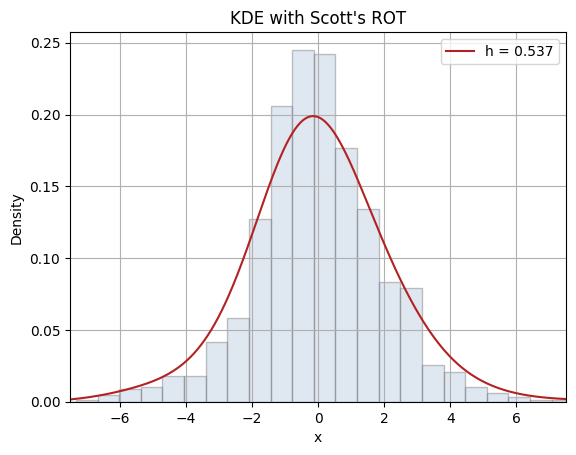

In [ ]:
label = "h = " + str(h_scott)
plt.hist(returns, bins=40, density=True,edgecolor='dimgrey', alpha=0.4, color='lightsteelblue')
plt.plot(x_values, KDE_Scott,color ='firebrick',label=label)
plt.xlabel('x')
plt.legend()
plt.ylabel('Density')
plt.xlim(-7.5,7.5)
plt.grid(True)
plt.title("KDE with Scott's ROT")
plt.show()

### Silverman's ROT

In [ ]:
def silverman_bandwidth(data, sigma):
    n = len(data)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    bandwidth = 0.9 * np.minimum(sigma, iqr/1.34) * n**(-0.2)
    return bandwidth

In [ ]:
h_silverman = round(silverman_bandwidth(returns, sigma),3)
print(f"An estimation of the bandwidth with Silverman's ROT is : ", h_silverman)

An estimation of the bandwidth with Silverman's ROT is :  0.367


In [ ]:
KDE_Silverman = [kernel_density_estimate(returns, x, h_silverman) for x in x_values]

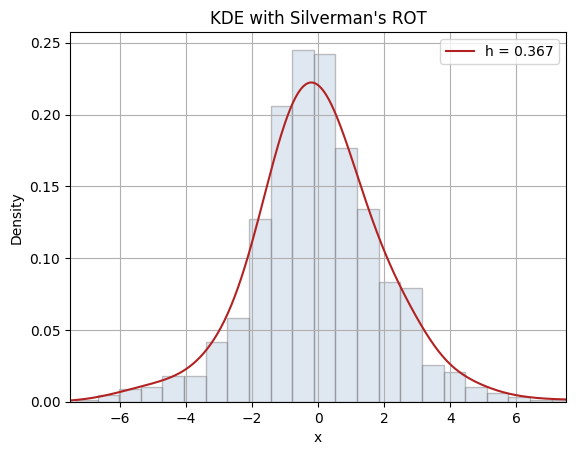

In [ ]:
label = "h = " + str(h_silverman)
plt.hist(returns, bins=40, density=True,edgecolor='dimgrey', alpha=0.4, color='lightsteelblue')
plt.plot(x_values, KDE_Silverman,color ='firebrick',label=label)
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.xlim(-7.5,7.5)
plt.grid(True)
plt.title("KDE with Silverman's ROT")
plt.show()

## Leave one out cross validation

In [ ]:
def MSE(true, pred):
  return np.mean((true - pred)**2)

In [ ]:
def LOOCV(returns, bandwidths, penalty) :

  mse_scores = np.zeros_like(bandwidths)
  for i, h in enumerate(bandwidths):

    mse_total = 0

    for j in range(len(returns)):
      density = kernel_density_estimate(returns, returns[j], h)

      mse = MSE(returns[j], density)
      mse_total += mse

    mse_avg = mse_total/len(returns)
    mse_scores[i] = mse_avg + penalty*h

  return bandwidths[np.argmin(mse_scores)]

In [ ]:
penalty= 1/len(returns)**0.5
#h_loocv = round(LOOCV(returns,np.linspace(0.1, 1, 20),penalty),3)
h_loocv = 0.858 #pour éviter le temps d'exécution
print('Optimal bandwidth with LOOCV :', h_loocv)

Optimal bandwidth with LOOCV : 0.858


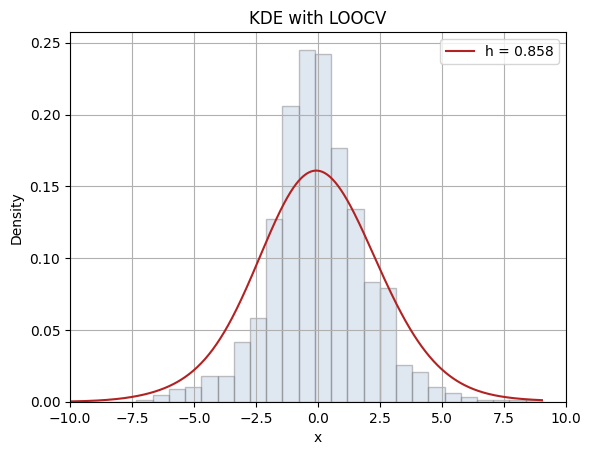

In [ ]:
LOOCV = [kernel_density_estimate(returns,x,h_loocv) for x in x_values]
label = "h = " + str(h_loocv)
plt.hist(returns, bins=40, density=True,edgecolor='dimgrey', alpha=0.4, color='lightsteelblue')
plt.plot(x_values, LOOCV, color='firebrick',label=label)
plt.xlabel('x')
plt.grid(True)
plt.xlim(-10,10)
plt.legend()
plt.ylabel('Density')
plt.title('KDE with LOOCV')
plt.show()

## Markov Chain Monte Carlo (MCMC)

The MCMC method is a sampling technique based on two important aspects of probabilities : Markov chains (sequence of random variables where the future value depends only on the present value and a transition probability) and Monte Carlo sampling.
The principle is simple and can be broken down into several parts:
  - Initialization: we give as input a value of h for which to start iterating
  - Proposition of a new value: we draw a new value of h from a Gaussian distribution centered on the previous value
  - Evaluation of the new value: we calculate the ratio between the density estimated at the new value on the density of the previous value
  - Acceptance or rejection of the new value: we draw an observation from a uniform law between 0 and 1 and we compare it with the probability of acceptance of the new value. If the latter is greater than the uniform observation, we keep the value and the put it into a list
  - Iterations: the MCMC process reaches a certain stationarity from a sufficiently large range after a burn-in phase, we must therefore iterate a large number of times to have a correct estimate. At the end of the iterations we calculate the average of the values.


In [ ]:
def MCMC_bandwidth(data, initial_bandwidth, normal_std, iterations):
    mu,sigma = parameters(data)
    current_bandwidth = initial_bandwidth
    accepted_samples = []
    acceptance_rates = []
    total_proposals = 0
    accepted_proposals = 0
    h_list = []

    for _ in range(iterations):
        # Generate a new proposal for bandwidth
        proposed_bandwidth = np.random.normal(current_bandwidth, normal_std)

        # Calculate the likelihoods for current and proposed bandwidths
        current_likelihood = np.prod(kernel_density_estimate(data, data, current_bandwidth))
        proposed_likelihood = np.prod(kernel_density_estimate(data, data, proposed_bandwidth))

        # Calculate the prior probabilities for current and proposed bandwidths
        current_prior = norm_pdf(current_bandwidth, mu, sigma)  # Example prior assuming a normal distribution
        proposed_prior = norm_pdf(proposed_bandwidth, mu, sigma)  # Example prior assuming a normal distribution

        # Calculate the acceptance probability
        acceptance_prob = min(1, (proposed_likelihood * proposed_prior) / (current_likelihood * current_prior))

        # Accept or reject the proposal based on the acceptance probability
        if np.random.uniform() < acceptance_prob:
            current_bandwidth = proposed_bandwidth
            accepted_samples.append(current_bandwidth)
            accepted_proposals += 1
            h_list.append(proposed_bandwidth)
        else:
          h_list.append(current_bandwidth)

        total_proposals += 1
        acceptance_rate = accepted_proposals / total_proposals
        acceptance_rates.append(acceptance_rate)

    return accepted_samples, acceptance_rates, h_list


  The process is sensitive to initial settings :

  - The sigma for proposal value distribution : This is the standard deviation of the normal distribution used to generate the jump proposals. A higher value of normal_std means that jump proposals will be more dispersed, which favors a broader exploration of the parameter space. This can be useful if you want better initial exploration of the parameter space. However, values ​​that are too high can result in inefficient exploration and a low acceptance rate.
  - The initial value : This value affects the starting point for bandwidth estimation. If the initial value is too small, the bandwidth estimate may be too small and approximate the data too smoothly. If the initial value is too large, the estimate may be too broad and give too rough an approximation.    
  - The number of iterations : A higher number of iterations generally allows better convergence to the target distribution. However, this can also increase the execution time of the algorithm.

Optimal bandwidth: -5.436
Acceptance rate: 1.0


Text(0.5, 1.0, 'Posterior Density')

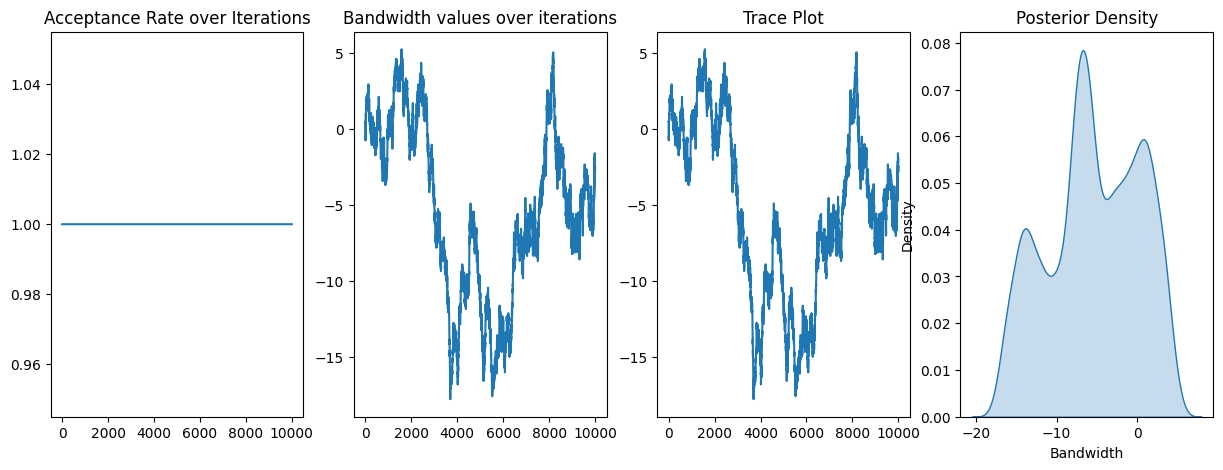

In [ ]:
initial_bandwidth = h_silverman
proposal_stddev = 0.2
num_iterations = 10000

accepted_samples, acceptance_rates,h_list = MCMC_bandwidth(returns, initial_bandwidth,proposal_stddev , num_iterations)

optimal_bandwidth = round(np.mean(accepted_samples), 3)
print("Optimal bandwidth:", optimal_bandwidth)
print("Acceptance rate:", acceptance_rates[-1])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

ax1.plot(range(num_iterations), acceptance_rates)
ax1.set_title("Acceptance Rate over Iterations")

ax2.plot(range(num_iterations), h_list)
ax2.set_title('Bandwidth values over iterations')

ax3.plot(accepted_samples)
ax3.set_title('Trace Plot')

sns.kdeplot(accepted_samples, fill=True, ax=ax4)
ax4.set_xlabel('Bandwidth')
ax4.set_ylabel('Density')
ax4.set_title('Posterior Density')

In [ ]:
KDE_MCMC = [kernel_density_estimate(returns, x, h_MCMC) for x in x_values]
string = "h=" + str(h_MCMC)
plt.hist(returns, bins=50, density=True, edgecolor='dimgrey',alpha=0.4, color='lightsteelblue')
plt.plot(x_values, KDE_MCMC,color ='firebrick',label=string)
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.xlim(-6,6)
plt.grid(True)
plt.title("KDE with MCMC")
plt.show()

NameError: name 'h_MCMC' is not defined

En prenant une fonction a priori qui est une loi normale 0 1 on obtient des résultats compris entre 0.36 et 0.44.
Si on prend maintenant une loi normale qui a les paramètres de notre distribution de rendement, on trouve des résultats de l'autre de 0.47 à 0.69.

## Probabily Integral Transform (PIT)

### Dynamic approach for KDE

The first goal is implementing the dynamic kernel in which data have different weights depending on the time :

In [ ]:
def recursive_dynamic_kernel(data, x, bandwidth, w, t0):
    t = len(data)
    weight = ((1 - w) * w ** (t - t0)) / (1 - w ** t0)
    kernel_vals = weight * norm_pdf(((x - data[t0]) / bandwidth), mu, sigma) / bandwidth
    for i in range(t0+1,t):
      kernel_vals = w * kernel_vals + ((1 - w) / bandwidth) * norm_pdf(((x - data[i]) / bandwidth), mu, sigma)
    return kernel_vals

In [ ]:
x_values = np.linspace(np.min(returns), np.max(returns), 1000)
recursive_KDE = [recursive_dynamic_kernel(returns, x, 0.4, 0.98, 200) for x in x_values]

In [ ]:
plt.hist(returns, bins=40, density=True,edgecolor='dimgrey', alpha=0.4, color='lightsteelblue')
plt.plot(x_values, recursive_KDE,color ='firebrick')
plt.xlabel('x')
plt.ylabel('Density')
plt.xlim(-10,10)
plt.grid(True)
plt.title("Recursive dynamic KDE")
plt.show()

### Dynamic CDF

In [ ]:
def dynamic_kernel_cdf(data, x, bandwidth, w, t0):
    t = len(data)
    mean, variance = parameters(data)
    kernel_vals_cdf =  0
    for i in range(t0):
      kernel_vals_cdf += w**(t0-i) * norm_cdf(((x - data[i]) / bandwidth), mean, variance**0.5) * ((1 - w) / (1 - w**t0))
    for i in range(t0+1,t):
      kernel_vals_cdf = w * kernel_vals_cdf + (1 - w) * norm_cdf(((x - data[i]) / bandwidth), mean, variance**0.5)
    return kernel_vals_cdf

In [ ]:
x_values = np.linspace(np.min(returns), np.max(returns), 1000)
recursive_CDF = [dynamic_kernel_cdf(returns, x, 0.4, 0.98, 200) for x in x_values]

In [ ]:
plt.plot(x_values, recursive_CDF,color ='firebrick')
plt.xlabel('x')
plt.ylabel('Density')
plt.xlim(-10,10)
plt.grid(True)
plt.title("Recursive KDE")
plt.show()

### PIT variables and statistics

In [ ]:
def Z(t, h, w, t0):
  return dynamic_kernel_cdf(returns, returns[t], h, w, t0)

In [ ]:
def k_uniformity(Z_vals, t0):
    T = len(Z_vals)
    maximum = 0
    for s in range(t0+1,T):
      somme = 0
      for u in range(t0+1,T):
          if (Z_vals[u] >= 0) and (Z_vals[u] <= Z_vals[s]):
            somme += 1
      diff = Z_vals[s] - (1/(T-t0+1)) * somme
      if abs(diff) > maximum:
        maximum = abs(diff)
    return maximum

In [ ]:
def k_independence(Z_vals, t0, tau):
    T = len(Z_vals)
    maximum = 0
    for s in range(t0+1, T-tau):
      somme = 0
      for u in range(t0+1,T-tau):
        if (Z_vals[u] >= 0) and (Z_vals[u] <= Z_vals[s]) and (Z_vals[u+tau] >= 0) and (Z_vals[u+tau] <= Z_vals[s+tau]):
          somme += 1
      diff = Z_vals[s]*Z_vals[s+tau] - (1/(T-tau-t0+1)) * somme
      if abs(diff) > maximum:
        maximum = abs(diff)
    return maximum

In [ ]:
def k_global(Z_vals, t0, tau):
  if tau == 0:
    k = k_uniformity(Z_vals, t0)
  else:
    k = k_independence(Z_vals, t0, tau)
  return k

In [ ]:
def d_nu(Z_vals, t0, nu):
    T = len(Z_vals)
    max_val = float('-inf')
    for tau in range(nu+1):
        statistic =(((T - tau - t0)**0.5)* k_global(Z_vals, t0, tau))
        if statistic > max_val:
            max_val = statistic
    return max_val

### Minimization

In [ ]:
t0 = 500
nu = 22 #It corresponds to the number of returns we have in the dataset for each month

min_statistic = float('inf')
h_PIT = None
w_PIT = None

h_values = np.linspace(0.3, 0.8, 6)
w_values = np.linspace(1-(1/nu), 0.99, 15)

for h in h_values:
    for w in w_values:
        Z_vals = [Z(t, h, w, t0) for t in range(t0+1, len(returns))]
        statistic = d_nu(Z_vals, t0, nu)
        if statistic < min_statistic:
            min_statistic = statistic
            h_PIT = h
            w_PIT = round(w,3)

print("Best h:", h_PIT)
print("Best w:", w_PIT)

In [ ]:
x_values = np.linspace(np.min(returns), np.max(returns), 1000)
KDE_PIT = [recursive_dynamic_kernel(returns, x, h_PIT, w_PIT, t0) for x in x_values]

In [ ]:
label = "h=" + str(h_PIT) + " w=" + str(w_PIT)
plt.hist(returns, bins=40, density=True,edgecolor='dimgrey', alpha=0.4, color='lightsteelblue')
plt.plot(x_values, KDE_PIT,color ='firebrick',label=label)
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.xlim(-10,10)
plt.grid(True)
plt.title("Optimised KDE")
plt.show()

## Libraries

### Kernel Regression

In [ ]:
returns = np.array(returns)
bandwidths = np.linspace(0.01, 2, 200)
cvls_scores = []

for h in bandwidths:
    kreg = KernelReg(returns, returns, var_type='c', bw=[h])
    cvls_score = np.mean((returns - kreg.fit(returns)[0]) ** 2)
    cvls_scores.append(cvls_score)

h_kernelreg = bandwidths[np.argmin(cvls_scores)]
print("Bandwidth with Stats model : ", h_kernelreg)

### Grid Search

In [ ]:
returns = np.array(returns)
param_grid = {'bandwidth': np.linspace(0.01, 2, 200)}
kde = KernelDensity()
grid_search = GridSearchCV(kde, param_grid, cv=5)
grid_search.fit(returns.reshape(-1, 1))

h_gridsearch = grid_search.best_params_['bandwidth']
print("Bandwidth with Sklearn : ",h_gridsearch)

### Libraries comparison

In [ ]:
KDE_kernelreg= [kernel_density_estimate(returns, x, h_kernelreg) for x in x_values]
KDE_gridsearch= [kernel_density_estimate(returns, x, h_gridsearch) for x in x_values]
label_reg = "Stats model: h=" + str(h_kernelreg)
label_gridsearch = "Sklearn : h=" + str(h_gridsearch)
plt.hist(returns, bins=40, density=True,edgecolor='dimgrey', alpha=0.4, color='lightsteelblue')
plt.plot(x_values, KDE_kernelreg,color ='firebrick',label=label_reg)
plt.plot(x_values, KDE_gridsearch,color ='violet',label=label_gridsearch)
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.xlim(-10,10)
plt.grid(True)
plt.title("KDE with libraries")
plt.show()

# Unimodal comparison


In [ ]:
plt.hist(returns, bins=50, density=True, edgecolor='dimgrey',alpha=0.4, color='lightsteelblue')
plt.plot(x_values, KDE_MCMC,color ='firebrick',label='MCMC')
plt.plot(x_values, KDE_Silverman,color ='blue',label='Silverman')
plt.plot(x_values, KDE_Scott,color ='green',label='Scott')
plt.plot(x_values, KDE_kernelreg,color ='orange',label='Stats_model')
plt.plot(x_values, KDE_gridsearch,color ='blueviolet',label='Sklearn')
plt.plot(x_values, LOOCV,color ='plum',label='LOOCV')
plt.plot(x_values, KDE_PIT,color ='gold',label='PIT')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.xlim(-7.5,7.5)
plt.grid(True)
plt.title("Methods comparison on unimodal data")
plt.show()

# Multimodal Comparison

In [ ]:
KDE_LSCV_l_m= [kernel_density_estimate(multimodal_data, x, h_kernelreg) for x in x_values]
KDE_LSCV_l2_m= [kernel_density_estimate(multimodal_data, x, h_gridsearch) for x in x_values]
KDE_Silverman_ROT_m = [kernel_density_estimate(multimodal_data, x, h_silverman) for x in x_values]
KDE_Scott_ROT_m = [kernel_density_estimate(multimodal_data, x, h_scott) for x in x_values]
KDE_MCMC_m = [kernel_density_estimate(multimodal_data, x, h_MCMC) for x in x_values]
LOOCV_m = [kernel_density_estimate(multimodal_data, x, h_loocv) for x in x_values]
PIT_m = [recursive_dynamic_kernel(multimodal_data, x, h_PIT, w_PIT, t0) for x in x_values]

In [ ]:
plt.hist(multimodal_data, bins=50, density=True,edgecolor='dimgrey', alpha=0.4, color='lightsteelblue')
plt.plot(x_values, KDE_MCMC_m,color ='firebrick',label='MCMC')
plt.plot(x_values, KDE_Silverman_ROT_m,color ='blue',label='Silverman')
plt.plot(x_values, KDE_Scott_ROT_m,color ='green',label='Scott')
plt.plot(x_values, KDE_LSCV_l_m,color ='orange',label='Stats_model_library')
plt.plot(x_values, KDE_LSCV_l2_m,color ='blueviolet',label='Sklearn library')
plt.plot(x_values, LOOCV_m,color ='plum',label='LOOCV')
plt.plot(x_values, PIT_m,color ='gold',label='PIT')
plt.xlabel('x')
plt.ylabel('Density')
plt.xlim(-5,5)
plt.grid(True)
plt.legend()
plt.title("Methods comparison on multimodal data")
plt.show()